This example demonstrates the calculation of bilayer fractional quantum Hall states using the Halperin (m,m',n) wavefunction.

## Physical System
- **Two-layer system**: Each layer can hold electrons with inter-layer tunneling
- **Halperin (m,m',n) state**: Generalization of Laughlin state to bilayer systems. For (3,3,1) state, the filling factors are 1/4 for both layers.
- **Inter-layer distance**: d
- **Tunneling strength**: t
- **Energy offset**: ΔE

## Key Features
- **Layer conservation**: Interaction conserves layer component of each scattering vertex (ci1=cf1, ci2=cf2)
- **Layer-dependent interaction**: Extra e^{-ql*d_l} factor for different-layer interaction

## System Parameters

### Lattice Geometry
- Triangular lattice with vectors G1 = (G, 0), G2 = (-G/2, sqrt(3)*G/2)
- Landau level n=0
- Brillouin zone area = 2π/l² = sqrt(0.75) * G²

### Bilayer Parameters
- **Nc = 2**: Number of layers (components)
- **Inter-layer distance**: d/l
- **Tunneling amplitude**: t / W0, if t=0, layer becomes conserved
- **Layer conservation**: Interactions preserve layer indices

### Interaction Details
- **Same-layer interaction**: Identical to single-layer case
- **Different-layer interaction**: Includes e^{-ql*d/l} attenuation factor
- **Form factor**: V(q) = W0 * 1/|ql| * tanh(|qD|) 

In [ ]:
# Import the momentum-conserved exact diagonalization package
using MomentumED

# Number of layers (components) for bilayer system
Nc_hopping = 2

# Define k-mesh for bilayer system (2×3 mesh, Nk=6) in triangular lattice
# Using a smaller mesh for computational efficiency
k_list = [0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2]
Nk = 12
Gk = (4, 3)  # Grid dimensions

# Total number of electrons (3 electrons across both layers)
Ne = 6

In [ ]:
# Physical parameters
Gl = sqrt(2π/sqrt(0.75))   # Magnetic length scale
D_l = 5.0                  # Screening length D/l
W0 = 1.0                   # Interaction strength
G12_angle = 2π/3           # Angle between reciprocal lattice vectors (triangular lattice)
d_l = 3.0                  # Inter-layer distance d/l
t = 0.0 * W0              # Inter-layer tunneling strength
ΔE = 0 * W0              # Energy difference between the two layers


# Define the form factor for Coulomb interaction in Landau level
# This includes the Landau level projection exp(-0.5 * q²l²)
# For bilayer: add extra e^{-ql*d/l} factor for different-layer interactions
function VFF_bilayer(q1::Float64, q2::Float64; diff_layer=false)
    ql = sqrt(q1^2 + q2^2 + 2cos(G12_angle) * q1*q2) * Gl
    if ql == 0.0
        return W0 * D_l  # Regularization at q=0
    end
    
    V = W0 / ql * tanh(ql * D_l) * exp(-0.5 * ql^2)
    
    # Apply inter-layer attenuation factor for different-layer interactions
    if diff_layer
        return V * exp(-ql * d_l)  # Exponential attenuation with distance d_l
    end
    
    return V
end

# Sign function for reciprocal lattice vectors
# Determines the phase structure of the magnetic translation group
function ita(g1::Int64, g2::Int64)
    if iseven(g1) && iseven(g2)
        return 1
    else
        return -1
    end
end

# Cross product for 2D vectors (returns scalar)
# Used for computing geometric phases in magnetic field
function ql_cross(q1_1, q1_2, q2_1, q2_2)
    return q1_1 * q2_2 - q1_2 * q2_1
end

# Bilayer interaction function - same structure as single-layer but with layer-dependent VFF
function V_int_bilayer(kf1, kf2, ki1, ki2, cf1=1, cf2=1, ci1=1, ci2=1; output=false)::ComplexF64
    
    # Layer conservation: interaction must conserve layer indices
    if ci1 != cf1 || ci2 != cf2
        return 0.0 + 0.0im
    end
    
    
    # Calculate momentum transfer (modulo reciprocal lattice)
    q = rem.(ki1 .- kf1, 1, RoundNearest)
    G_shift1 = round.(Int64, ki1 .- kf1 .- q, RoundNearest)
    G_shift2 = round.(Int64, kf2 .- ki2 .- q, RoundNearest)


    V_total = ComplexF64(0.0)
    # Sum over reciprocal lattice vectors for convergence
    Nshell = 2
    for g1 in -Nshell:Nshell, g2 in -Nshell:Nshell
        if abs(g1-g2) > Nshell
            continue
        end

        # Construct the full momentum transfer including reciprocal lattice
        qq1 = q[1] + g1
        qq2 = q[2] + g2

        # Calculate phase factors from magnetic translation algebra
        # These phases ensure proper commutation relations and gauge invariance
        phase_angle = 0.5ql_cross(ki1[1], ki1[2], kf1[1], kf1[2])
        phase_angle += 0.5ql_cross(ki1[1]+kf1[1], ki1[2]+kf1[2], qq1, qq2)
        phase_angle += 0.5ql_cross(ki2[1], ki2[2], kf2[1], kf2[2])
        phase_angle += 0.5ql_cross(ki2[1]+kf2[1], ki2[2]+kf2[2], -qq1, -qq2)

        phase = cispi(2.0phase_angle)
        sign = ita(g1+G_shift1[1], g2+G_shift1[2]) * ita(g1+G_shift2[1], g2+G_shift2[2])

        # Use layer-dependent form factor
        vff = VFF_bilayer(qq1, qq2; diff_layer=(ci1 != ci2))
        V_total += sign * phase * vff
    end

    return V_total
end

# Set up one-body Hamiltonian matrix for inter-layer tunneling
# H_onebody[c1, c2, cc, k] : hopping from component c2 to c1 at momentum k
# For bilayer system: Nc_hopping=2, Nc_conserve=1, Nk=6
H_onebody_bilayer = zeros(ComplexF64, Nc_hopping, Nc_hopping, 1, Nk)

# Add tunneling terms: t = 0.5 * W0 between different layers
# Tunneling conserves momentum (diagonal in k-space)
for k_idx in 1:Nk
    # Hopping from layer 2 to layer 1
    H_onebody_bilayer[1, 2, 1, k_idx] = t
    # Hopping from layer 1 to layer 2  
    H_onebody_bilayer[2, 1, 1, k_idx] = t
    H_onebody_bilayer[1, 1, 1, k_idx] = 0.5ΔE
    H_onebody_bilayer[2, 2, 1, k_idx] = -0.5ΔE
end

# Create parameter structure for bilayer system
# Note: H_onebody matrix handles tunneling, V_int handles interactions
para_bilayer = EDPara(
    k_list=k_list, 
    Gk=Gk, 
    Nc_hopping=Nc_hopping,
    Nc_conserve=1,
    H_onebody=H_onebody_bilayer,
    V_int=V_int_bilayer
);

In [ ]:
# Create momentum blocks for bilayer system
blocks, block_k1, block_k2, k0number = 
    ED_momentum_block_division(para_bilayer, ED_mbslist(para_bilayer, (Ne,)));
length.(blocks)

In [ ]:
# Generate scattering lists for efficient Hamiltonian construction
scat_list1 = ED_sortedScatteringList_onebody(para_bilayer);
scat_list2 = ED_sortedScatteringList_twobody(para_bilayer);

In [ ]:
energies = Vector{Vector{Float64}}(undef, length(blocks))
Neigen = 6
for i in eachindex(blocks)
    println("Processing block #$i with size $(length(blocks[i])), momentum $(block_k1[i]), $(block_k2[i])")
    energies[i] = EDsolve(blocks[i], scat_list1, scat_list2, Neigen; showtime=true, converge_warning = false)[1]
end

In [ ]:
# The package for plotting is not included in this package. Use the following to add it:
# using Pkg; Pkg.add("CairoMakie")

In [ ]:
# Plot energy spectrum
using CairoMakie
CairoMakie.activate!()

begin
    fig = Figure();
    ax = Axis(fig[1, 1])    
    # Plot energy levels for each momentum block
    for i in 1:length(blocks)
        for e in energies[i]
            scatter!(ax, Gk[2]*block_k1[i]+block_k2[i], e, color = :blue, marker=:hline)
        end
    end
    fig
end
display(fig)

In [8]:
# check energies explicitly to see if there's degeneracy in the same momentum sector.
energies[4]

6-element Vector{Float64}:
 4.767925049245063
 4.767925049245064
 4.830820342284234
 4.830820342284238
 4.843752888025073
 4.8437528880250795

In the specific case when interlayer tunneling t=0, particle numbers of the two layers are conserved.

Therefore, we can do larger system.

In [ ]:
# Import the momentum-conserved exact diagonalization package
using MomentumED

# Number of layers (components) for bilayer system
Nc_conserve = 2

# Define k-mesh for bilayer system (2×3 mesh, Nk=6) in triangular lattice
# Using a smaller mesh for computational efficiency
k_list = [0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]
Nk = 16
Gk = (4, 4)  # Grid dimensions

# Total number of electrons (3 electrons across both layers)
Ne1 = 4
Ne2 = 4

In [ ]:
# Physical parameters
t = 0.0                    # must be zero for layer-conserved case
ΔE = 0 * W0                # Energy difference between the two layers


# Set up one-body Hamiltonian matrix for inter-layer tunneling
# H_onebody[c1, c2, cc, k] : no hopping from component c2 to c1
# For bilayer system: Nc_hopping=1, Nc_conserve=2, Nk=6
H_onebody_bilayer = zeros(ComplexF64, 1, 1, Nc_conserve, Nk)
# Add energy difference terms: ΔE = 0.5 * W0 between different layers
# No tunneling
for k_idx in 1:Nk
    H_onebody_bilayer[1, 1, 1, k_idx] = 0.5ΔE
    H_onebody_bilayer[1, 1, 2, k_idx] = -0.5ΔE
end

# Create parameter structure for bilayer system
# Note: H_onebody matrix handles tunneling, V_int handles interactions
para_bilayer = EDPara(
    k_list=k_list, 
    Gk=Gk, 
    Nc_hopping=1,
    Nc_conserve=Nc_conserve,
    H_onebody=H_onebody_bilayer,
    V_int=V_int_bilayer
);

In [ ]:
# Create momentum blocks for bilayer system
blocks, block_k1, block_k2, k0number = 
    ED_momentum_block_division(para_bilayer, ED_mbslist(para_bilayer, (Ne1,Ne2)));
length.(blocks)

In [ ]:
# Generate scattering lists for efficient Hamiltonian construction
scat_list1 = ED_sortedScatteringList_onebody(para_bilayer);
scat_list2 = ED_sortedScatteringList_twobody(para_bilayer);

In [ ]:
# Time cost is significantly higher with this larger system size
energies = Vector{Vector{Float64}}(undef, length(blocks))
Neigen = 6
for i in eachindex(blocks)
    println("Processing block #$i with size $(length(blocks[i])), momentum $(block_k1[i]), $(block_k2[i])")
    if i == k0number
        energies[i] = EDsolve(blocks[i], scat_list1, scat_list2, 2Neigen; showtime=true, converge_warning = false)[1]
    else
        energies[i] = EDsolve(blocks[i], scat_list1, scat_list2, Neigen; showtime=true, converge_warning = false)[1]
    end
end

Processing block #1 with size 207184, momentum 0, 0
 25.401103 seconds (1.48 G allocations: 27.103 GiB, 16.87% gc time, 5.16% compilation time)
 86.661962 seconds (120.95 k allocations: 9.353 GiB, 2.23% gc time, 0.08% compilation time: 73% of which was recompilation)
Processing block #2 with size 206976, momentum 0, 1


┌ Warning: Lanczos eigsolve stopped without convergence after 100 iterations:
│ * 8 eigenvalues converged
│ * norm of residuals = (3.35e-25, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.71e-09, 1.02e-08, 3.72e-08, 2.35e-08)
│ * number of operations = 1182
└ @ KrylovKit C:\Users\zoubo\.julia\packages\KrylovKit\iz9bA\src\eigsolve\lanczos.jl:138


 28.901823 seconds (1.48 G allocations: 27.066 GiB, 18.21% gc time)
 78.559922 seconds (21.23 k allocations: 8.209 GiB, 2.32% gc time)
Processing block #3 with size 207168, momentum 0, 2
 28.799553 seconds (1.48 G allocations: 27.093 GiB, 17.67% gc time)
 84.396502 seconds (21.84 k allocations: 8.489 GiB, 2.32% gc time)
Processing block #4 with size 206976, momentum 0, 3
 29.059163 seconds (1.48 G allocations: 27.066 GiB, 19.47% gc time)
 75.059982 seconds (21.39 k allocations: 8.160 GiB, 2.47% gc time)
Processing block #5 with size 206976, momentum 1, 0
 27.448053 seconds (1.48 G allocations: 27.066 GiB, 18.03% gc time)
 73.536148 seconds (20.59 k allocations: 8.006 GiB, 2.35% gc time)
Processing block #6 with size 206976, momentum 1, 1
 26.076573 seconds (1.48 G allocations: 27.066 GiB, 19.23% gc time)
 72.481436 seconds (21.11 k allocations: 8.067 GiB, 2.39% gc time)
Processing block #7 with size 206976, momentum 1, 2
 27.436795 seconds (1.48 G allocations: 27.066 GiB, 18.90% gc tim

┌ Warning: Lanczos eigsolve stopped without convergence after 100 iterations:
│ * 4 eigenvalues converged
│ * norm of residuals = (2.46e-19, 4.47e-19, 5.21e-19, 1.26e-19, 1.81e-12, 1.58e-11)
│ * number of operations = 1201
└ @ KrylovKit C:\Users\zoubo\.julia\packages\KrylovKit\iz9bA\src\eigsolve\lanczos.jl:138


 25.161865 seconds (1.48 G allocations: 27.066 GiB, 17.98% gc time)
 60.968049 seconds (18.38 k allocations: 7.105 GiB, 2.44% gc time)
Processing block #11 with size 207168, momentum 2, 2
 24.702136 seconds (1.48 G allocations: 27.093 GiB, 18.36% gc time)
 70.507057 seconds (21.00 k allocations: 8.198 GiB, 2.52% gc time)
Processing block #12 with size 206976, momentum 2, 3
 26.498147 seconds (1.48 G allocations: 27.066 GiB, 19.10% gc time)


In [75]:
# The package for plotting is not included in this package. Use the following to add it:
# using Pkg; Pkg.add("CairoMakie")

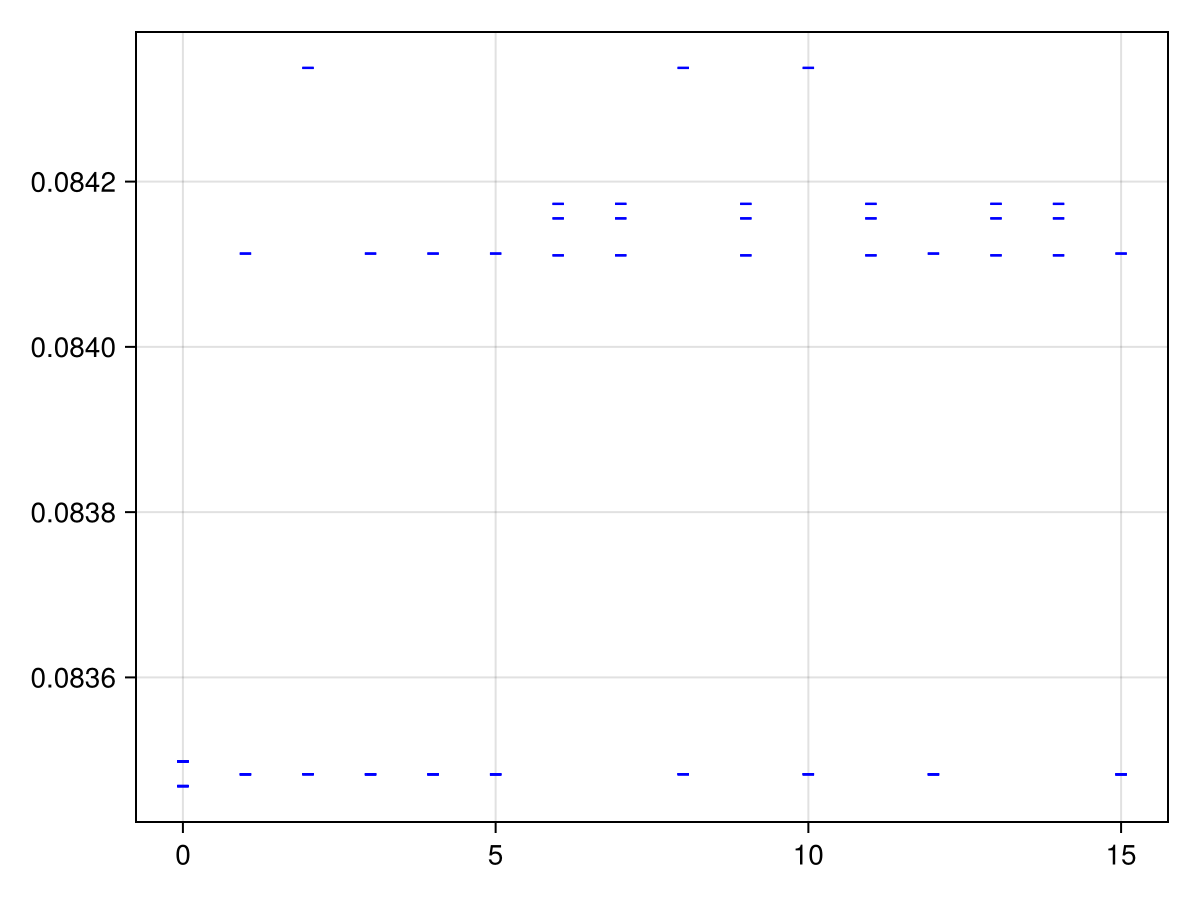

CairoMakie.Screen{IMAGE}


In [76]:
# Plot energy spectrum
using CairoMakie
CairoMakie.activate!()

begin
    fig = Figure();
    ax = Axis(fig[1, 1])    
    # Plot energy levels for each momentum block
    for i in 1:length(blocks)
        for e in energies[i]
            scatter!(ax, Gk[2]*block_k1[i]+block_k2[i], e, color = :blue, marker=:hline)
        end
    end
    fig
end
display(fig)

In [78]:
# check energies explicitly to see if there's degeneracy in the same momentum sector.
energies[2]

6-element Vector{Float64}:
 0.0834826314776215
 0.08348266506642925
 0.08348266640383772
 0.0834826986733487
 0.08411288032408262
 0.08411288054247594